# Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from PIL import Image
import pandas as pd
import numpy as np
import cv2
import random
import os

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [3]:
# Directory paths
train_dir = "./dataset/train"
test_dir = "./dataset/test"

In [4]:
# Get file paths for training set
train_no_mental = []
train_mental = []

for i in range(1, 70):
    folder_num = str(i).zfill(3)
    
    no_mental_path = os.path.join(train_dir, folder_num)
    mental_path = os.path.join(train_dir, f"{folder_num}_forg")
    
    if os.path.exists(no_mental_path):
        train_no_mental.extend([os.path.join(no_mental_path, x) 
                              for x in os.listdir(no_mental_path) 
                              if x.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if os.path.exists(mental_path):    
        train_mental.extend([os.path.join(mental_path, x) 
                           for x in os.listdir(mental_path)
                           if x.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Get file paths for test set
test_no_mental = []
test_mental = []

for i in range(1, 70):
    folder_num = str(i).zfill(3)
    
    no_mental_path = os.path.join(test_dir, folder_num)
    mental_path = os.path.join(test_dir, f"{folder_num}_forg")
    
    if os.path.exists(no_mental_path):
        test_no_mental.extend([os.path.join(no_mental_path, x)
                             for x in os.listdir(no_mental_path)
                             if x.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if os.path.exists(mental_path):
        test_mental.extend([os.path.join(mental_path, x)
                          for x in os.listdir(mental_path)
                          if x.lower().endswith(('.png', '.jpg', '.jpeg'))])

In [5]:
# Create binary labels (0: No Mental Disorder, 1: Mental Disorder)
train_no_mental_labels = [0] * len(train_no_mental)
train_mental_labels = [1] * len(train_mental)
test_no_mental_labels = [0] * len(test_no_mental)
test_mental_labels = [1] * len(test_mental)

In [6]:
# Combine data and labels
X_train = train_no_mental + train_mental
y_train = train_no_mental_labels + train_mental_labels
X_test = test_no_mental + test_mental
y_test = test_no_mental_labels + test_mental_labels

def prepare_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))
    img_array = np.expand_dims(img, axis=-1)
    img_array = img_array / 255.0
    return img_array

In [7]:
# Prepare training and testing data
X_train_processed = np.array([prepare_image(img_path) for img_path in X_train])
X_test_processed = np.array([prepare_image(img_path) for img_path in X_test])
y_train = np.array(y_train)
y_test = np.array(y_test)

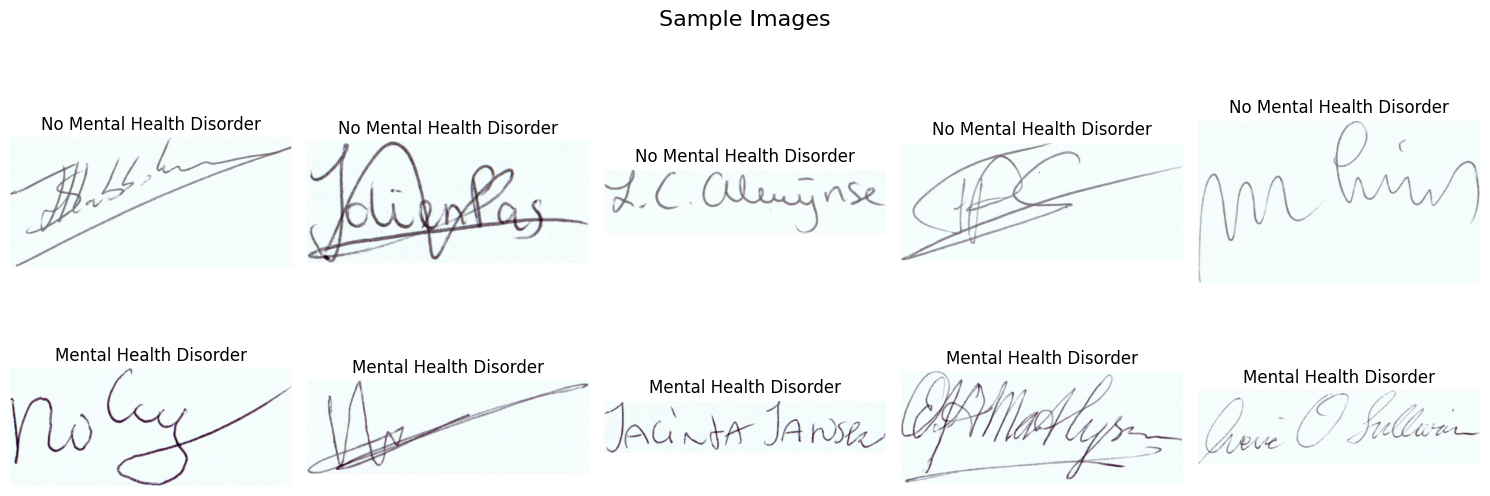

In [8]:
# Show sample images
plt.figure(figsize=(15,6))
plt.suptitle("Sample Images", fontsize=16)

# Show 5 normal samples
for i in range(5):
    plt.subplot(2, 5, i+1)
    img = cv2.imread(random.choice(train_no_mental))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('No Mental Health Disorder')
    plt.axis('off')

# Show 5 mental health samples
for i in range(5):
    plt.subplot(2, 5, i+6)
    img = cv2.imread(random.choice(train_mental))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title('Mental Health Disorder')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
print(f"Training samples - No Mental Health Disorder: {len(train_no_mental)}, Mental Health Disorder: {len(train_mental)}")
print(f"Testing samples - No Mental Health Disorder: {len(test_no_mental)}, Mental Health Disorder: {len(test_mental)}")

Training samples - No Mental Health Disorder: 887, Mental Health Disorder: 762
Testing samples - No Mental Health Disorder: 252, Mental Health Disorder: 248


# Build Model

In [10]:
# Build Sequential CNN model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [11]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['accuracy'])

In [12]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,473 (33.48 MB)

 Trainable params: 8,777,473 (33.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(
    './checkpoint/model_checkpoint.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [14]:
# Training with explicit validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [15]:
# Train model
history = model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.5206 - loss: 0.6966 - val_accuracy: 0.5394 - val_loss: 0.6834
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.5961 - loss: 0.6747 - val_accuracy: 0.7212 - val_loss: 0.5973
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.7392 - loss: 0.5496 - val_accuracy: 0.7515 - val_loss: 0.5175
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7710 - loss: 0.4785 - val_accuracy: 0.7515 - val_loss: 0.5256
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8015 - loss: 0.4382 - val_accuracy: 0.8000 - val_loss: 0.4603
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.8358 - loss: 0.3806 - val_accuracy: 0.8091 - val_loss: 0.4142
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.8618 - loss: 0.3420 - val_accuracy: 0.8333 - val_loss: 0.3729
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8641 - loss: 0.3191 - val_accuracy: 0.

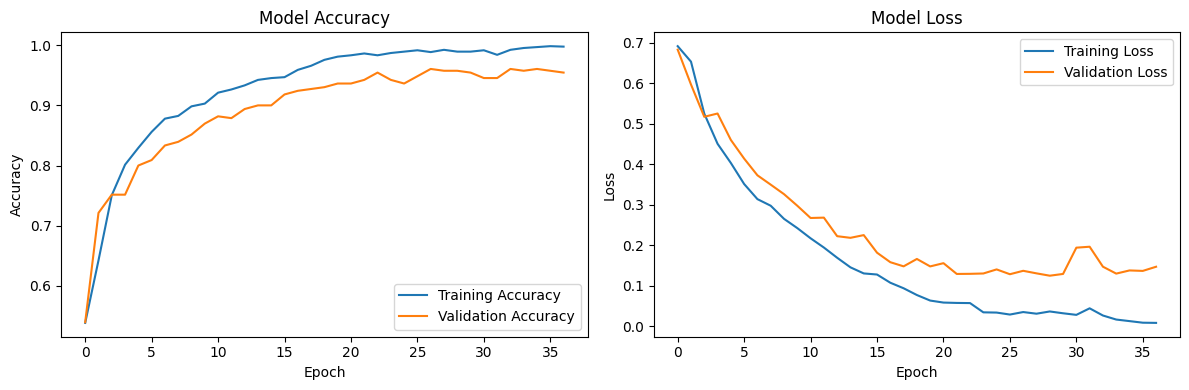

In [16]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Eval

In [17]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test_processed, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9955 - loss: 0.0197

Test Loss: 0.0298
Test Accuracy: 0.9920


In [18]:
# Get predictions
test_predictions = model.predict(X_test_processed)
binary_predictions = (test_predictions > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [19]:
# Print metrics
print("\nClassification Report:")
print(classification_report(y_test, binary_predictions, 
                          target_names=['No Mental Disorder', 'Mental Disorder']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, binary_predictions))


Classification Report:
                    precision    recall  f1-score   support

No Mental Disorder       0.99      1.00      0.99       252
   Mental Disorder       1.00      0.99      0.99       248

          accuracy                           0.99       500
         macro avg       0.99      0.99      0.99       500
      weighted avg       0.99      0.99      0.99       500


Confusion Matrix:
[[251   1]
 [  3 245]]


Confidence in this context is the model's prediction probability, ranging from 0 to 1, where:

0 = Model is completely certain it's "No Mental Disorder"
1 = Model is completely certain it's "Mental Disorder"
0.5 = Model is uncertain (50/50)

In [22]:
# Function to predict single image
def predict_image(image_path):
    img = prepare_image(image_path)
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)[0][0]
    result = "Mental Disorder" if prediction > 0.5 else "No Mental Disorder"
    return result, prediction

In [27]:
# Example usage
result, confidence = predict_image("image4.jpg")
print(f"Prediction: {result}")
print(f"Confidence: {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction: Mental Disorder
Confidence: 1.00


Testing No Mental Disorder samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 09_049.png
Prediction: No Mental Disorder
Confidence: 0.00


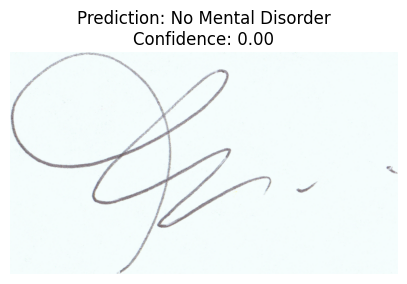

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 08_049.png
Prediction: No Mental Disorder
Confidence: 0.00


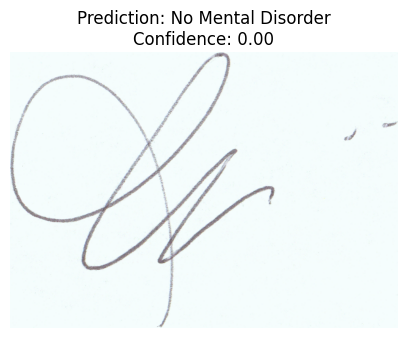

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 12_050.png
Prediction: No Mental Disorder
Confidence: 0.00


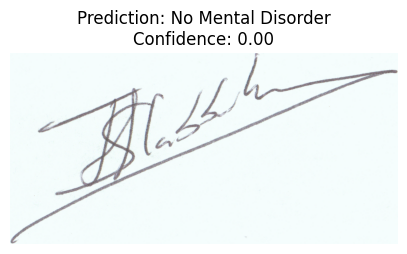

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Image: 08_053.png
Prediction: No Mental Disorder
Confidence: 0.02


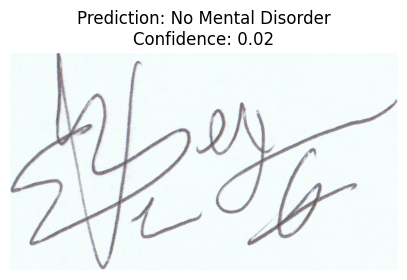

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Image: 12_053.png
Prediction: No Mental Disorder
Confidence: 0.11


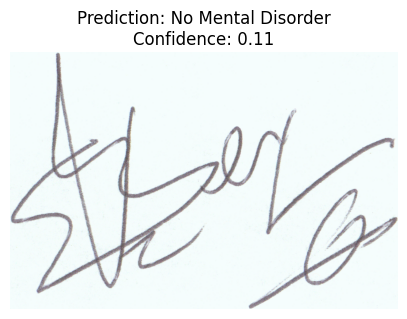

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Image: 10_059.png
Prediction: No Mental Disorder
Confidence: 0.00


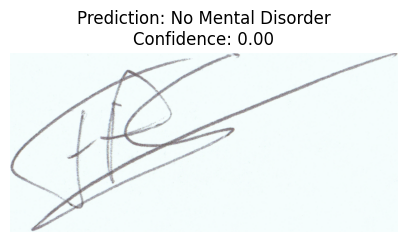

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Image: 11_061.png
Prediction: No Mental Disorder
Confidence: 0.00


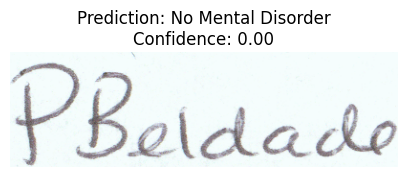

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 07_049.png
Prediction: No Mental Disorder
Confidence: 0.01


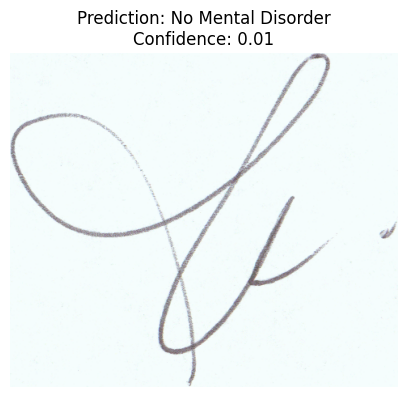

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Image: 12_060.png
Prediction: No Mental Disorder
Confidence: 0.02


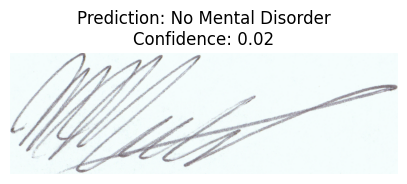

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Image: 03_053.png
Prediction: No Mental Disorder
Confidence: 0.05


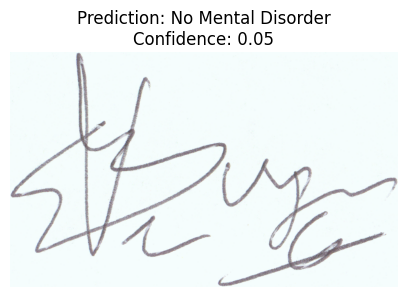


Testing Mental Disorder samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Image: 03_0108063.PNG
Prediction: Mental Disorder
Confidence: 1.00


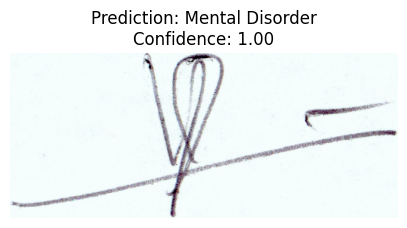

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 01_0201062.PNG
Prediction: Mental Disorder
Confidence: 1.00


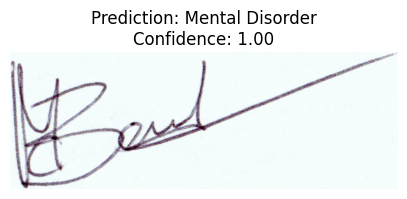

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 02_0104063.PNG
Prediction: Mental Disorder
Confidence: 1.00


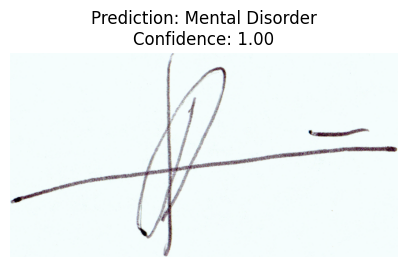

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Image: 04_0125059.PNG
Prediction: Mental Disorder
Confidence: 1.00


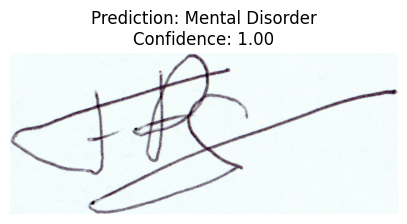

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Image: 02_0117057.PNG
Prediction: Mental Disorder
Confidence: 1.00


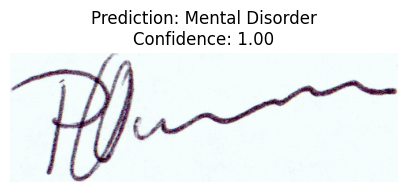

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Image: 03_0107053.PNG
Prediction: Mental Disorder
Confidence: 1.00


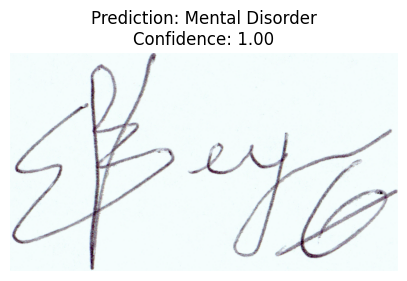

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Image: 04_0208057.PNG
Prediction: Mental Disorder
Confidence: 1.00


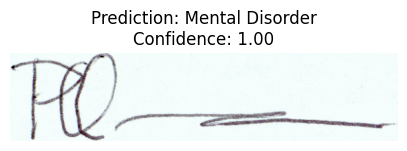

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 04_0121060.PNG
Prediction: Mental Disorder
Confidence: 1.00


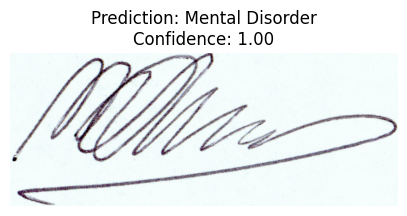

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Image: 02_0207054.PNG
Prediction: Mental Disorder
Confidence: 1.00


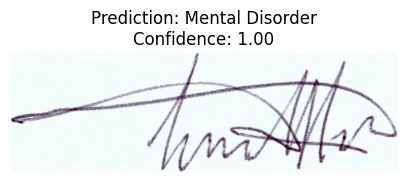

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Image: 01_0212066.PNG
Prediction: Mental Disorder
Confidence: 1.00


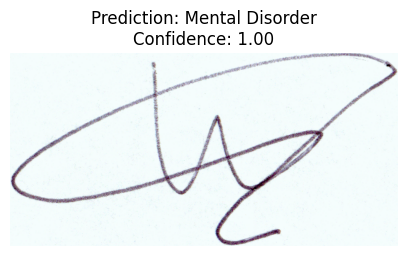


Overall Test Set Performance:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━

In [28]:
# Test predictions on multiple samples
test_samples = 10
random_indices_no_mental = random.sample(range(len(test_no_mental)), test_samples)
random_indices_mental = random.sample(range(len(test_mental)), test_samples)

print("Testing No Mental Disorder samples:")
for idx in random_indices_no_mental:
    img_path = test_no_mental[idx]
    result, confidence = predict_image(img_path)
    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}")
    
    # Display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f'Prediction: {result}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

print("\nTesting Mental Disorder samples:")
for idx in random_indices_mental:
    img_path = test_mental[idx]
    result, confidence = predict_image(img_path)
    print(f"\nImage: {os.path.basename(img_path)}")
    print(f"Prediction: {result}")
    print(f"Confidence: {confidence:.2f}")
    
    # Display the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f'Prediction: {result}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

# Calculate accuracy on full test set
test_accuracies = []
test_confidences = []

print("\nOverall Test Set Performance:")
for img_path, true_label in zip(test_no_mental + test_mental, [0]*len(test_no_mental) + [1]*len(test_mental)):
    result, confidence = predict_image(img_path)
    pred_label = 1 if result == "Mental Disorder" else 0
    test_accuracies.append(pred_label == true_label)
    test_confidences.append(confidence)

print(f"Average Accuracy: {np.mean(test_accuracies):.4f}")
print(f"Average Confidence: {np.mean(test_confidences):.4f}")
print(f"Confidence Standard Deviation: {np.std(test_confidences):.4f}")

In [31]:
# Save as .h5
model.save('./model/mental_health_model.h5')

# Save as .keras
model.save('./model/mental_health_model.keras')

# Save model architecture as JSON
model_json = model.to_json()
with open('./model/mental_health_model.json', 'w') as json_file:
    json_file.write(model_json)
    
# Save weights separately in h5 format
model.save_weights('./model/mental_health_model.weights.h5')

print("Model saved in multiple formats in ./model directory")

Model saved in multiple formats in ./model directory
